In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import skimage.io
import matplotlib.pyplot as plt
from skimage import transform
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from subprocess import check_output

%matplotlib inline

In [2]:
DATA_DIR = './data/stage1_train/'

BATCH_SIZE = 64

RESIZED_HEIGHT = 560
RESIZED_WIDTH = 560
N_CHANNELS = 4

In [3]:
def read_image_labels(image_id):
    # most of the content in this function is taken from 'Example Metric Implementation' kernel 
    # by 'William Cukierski'
    image_file = os.path.join(DATA_DIR, "{}/images/{}.png".format(image_id,image_id))
    mask_file = os.path.join(DATA_DIR, "{}/masks/*.png".format(image_id))
    image = skimage.io.imread(image_file)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = index + 1
    return image, labels

def data_aug(image,label,angel=30,resize_rate=0.9):
    flip = random.randint(0, 1)
    size = image.shape[0]
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    # Create Afine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    # Apply transform to image data
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    # Randomly corpping image frame
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
    return image, label

In [4]:
def make_data_augmentation(image_ids,split_num):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        image,labels = read_image_labels(image_id)
        if not os.path.exists(os.path.join(DATA_DIR, "{}/augs/".format(image_id))):
            os.makedirs(os.path.join(DATA_DIR, "{}/augs/".format(image_id)))
        if not os.path.exists(os.path.join(DATA_DIR, "{}/augs_masks/".format(image_id))):
            os.makedirs(os.path.join(DATA_DIR, "{}/augs_masks/".format(image_id)))
            
        # also save the original image in augmented file 
        plt.imsave(fname=os.path.join(DATA_DIR, "{}/augs/{}.png".format(image_id,image_id)), arr = image)
        plt.imsave(fname=os.path.join(DATA_DIR, "{}/augs_masks/{}.png".format(image_id,image_id)),arr = labels)

        for i in range(split_num):
            new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
            aug_img_dir = os.path.join(DATA_DIR, "{}/augs/{}_{}.png".format(image_id,image_id,i))
            aug_mask_dir = os.path.join(DATA_DIR, "{}/augs_masks/{}_{}.png".format(image_id,image_id,i))
            plt.imsave(fname=aug_img_dir, arr = new_image)
            plt.imsave(fname=aug_mask_dir,arr = new_labels)

def clean_data_augmentation(image_ids):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        if os.path.exists(os.path.join(DATA_DIR, "{}/augs/".format(image_id))):
            shutil.rmtree(os.path.join(DATA_DIR, "{}/augs/".format(image_id)))
        if os.path.exists(os.path.join(DATA_DIR, "{}/augs_masks/".format(image_id))):
            shutil.rmtree(os.path.join(DATA_DIR, "{}/augs_masks/".format(image_id)))

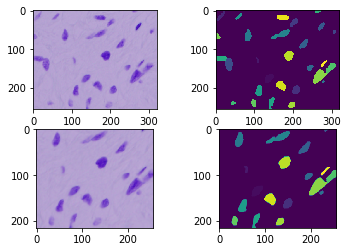

In [5]:
image_ids = os.listdir(DATA_DIR)
image_id = image_ids[random.randint(0,len(image_ids))]
image, labels = read_image_labels(image_id)
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(labels)

new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.8)
plt.subplot(223)
plt.imshow(new_image)
plt.subplot(224)
plt.imshow(new_labels)

In [6]:
def make_data_augmentation(image_ids,split_num):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        image,labels = read_image_labels(image_id)
        if not os.path.exists(DATA_DIR+"/{}/augs/".format(image_id)):
            os.makedirs(DATA_DIR+"/{}/augs/".format(image_id))
        if not os.path.exists(DATA_DIR+"/{}/augs_masks/".format(image_id)):
            os.makedirs(DATA_DIR+"/{}/augs_masks/".format(image_id))
            
        # also save the original image in augmented file 
        plt.imsave(fname=DATA_DIR+"/{}/augs/{}.png".format(image_id,image_id), arr = image)
        plt.imsave(fname=DATA_DIR+"/{}/augs_masks/{}.png".format(image_id,image_id),arr = labels)

        for i in range(split_num):
            new_image, new_labels = data_aug(image,labels,angel=5,resize_rate=0.9)
            aug_img_dir = DATA_DIR+"/{}/augs/{}_{}.png".format(image_id,image_id,i)
            aug_mask_dir = DATA_DIR+"/{}/augs_masks/{}_{}.png".format(image_id,image_id,i)
            plt.imsave(fname=aug_img_dir, arr = new_image)
            plt.imsave(fname=aug_mask_dir,arr = new_labels)

def clean_data_augmentation(image_ids):
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        if os.path.exists(DATA_DIR+"/{}/augs/".format(image_id)):
            shutil.rmtree(DATA_DIR+"/{}/augs/".format(image_id))
        if os.path.exists(DATA_DIR+"/{}/augs_masks/".format(image_id)):
            shutil.rmtree(DATA_DIR+"/{}/augs_masks/".format(image_id))


#image_ids = check_output(["ls", DATA_DIR+"/"]).decode("utf8").split()
split_num = 10
#make_data_augmentation(image_ids,split_num)
#clean_data_augmentation(image_ids)

In [38]:
def loss_function(y_pred, y_true):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=y_true))
    return cost

def mean_iou(y_pred,y_true):
    y_pred_ = tf.to_int64(y_pred > 0.5)
    y_true_ = tf.to_int64(y_true > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true_, y_pred_, 2)
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

def get_variable(name,shape):
    return tf.get_variable(name, shape, initializer = tf.contrib.layers.xavier_initializer())


In [8]:
def UNet(X):
    ### Unit 1 ###
    with tf.name_scope('Unit1'):
        W1_1 =   get_variable("W1_1", [3,3,3,16] )
        Z1 = tf.nn.conv2d(X,W1_1, strides = [1,1,1,1], padding = 'SAME')
        A1 = tf.nn.relu(Z1)
        W1_2 =   get_variable("W1_2", [3,3,16,16] )
        Z2 = tf.nn.conv2d(A1,W1_2, strides = [1,1,1,1], padding = 'SAME')
        A2 = tf.nn.relu(Z2) 
        P1 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 2 ###
    with tf.name_scope('Unit2'):
        W2_1 =   get_variable("W2_1", [3,3,16,32] )
        Z3 = tf.nn.conv2d(P1,W2_1, strides = [1,1,1,1], padding = 'SAME')
        A3 = tf.nn.relu(Z3)
        W2_2 =   get_variable("W2_2", [3,3,32,32] )
        Z4 = tf.nn.conv2d(A3,W2_2, strides = [1,1,1,1], padding = 'SAME')
        A4 = tf.nn.relu(Z4) 
        P2 = tf.nn.max_pool(A4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 3 ###
    with tf.name_scope('Unit3'):
        W3_1 =   get_variable("W3_1", [3,3,32,64] )
        Z5 = tf.nn.conv2d(P2,W3_1, strides = [1,1,1,1], padding = 'SAME')
        A5 = tf.nn.relu(Z5)
        W3_2 =   get_variable("W3_2", [3,3,64,64] )
        Z6 = tf.nn.conv2d(A5,W3_2, strides = [1,1,1,1], padding = 'SAME')
        A6 = tf.nn.relu(Z6) 
        P3 = tf.nn.max_pool(A6, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 4 ###
    with tf.name_scope('Unit4'):
        W4_1 =   get_variable("W4_1", [3,3,64,128] )
        Z7 = tf.nn.conv2d(P3,W4_1, strides = [1,1,1,1], padding = 'SAME')
        A7 = tf.nn.relu(Z7)
        W4_2 =   get_variable("W4_2", [3,3,128,128] )
        Z8 = tf.nn.conv2d(A7,W4_2, strides = [1,1,1,1], padding = 'SAME')
        A8 = tf.nn.relu(Z8) 
        P4 = tf.nn.max_pool(A8, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    ### Unit 5 ###
    with tf.name_scope('Unit5'):
        W5_1 =   get_variable("W5_1", [3,3,128,256] )
        Z9 = tf.nn.conv2d(P4,W5_1, strides = [1,1,1,1], padding = 'SAME')
        A9 = tf.nn.relu(Z9)
        W5_2 =   get_variable("W5_2", [3,3,256,256] )
        Z10 = tf.nn.conv2d(A9,W5_2, strides = [1,1,1,1], padding = 'SAME')
        A10 = tf.nn.relu(Z10) 
    ### Unit 6 ###
    with tf.name_scope('Unit6'):
        W6_1 =   get_variable("W6_1", [3,3,256,128] )
        U1 = tf.layers.conv2d_transpose(A10, filters = 128, kernel_size = 2, strides = 2, padding = 'SAME')
        U1 = tf.concat([U1, A8],3)
        W6_2 =   get_variable("W6_2", [3,3,128,128] )
        Z11 = tf.nn.conv2d(U1,W6_1, strides = [1,1,1,1], padding = 'SAME')
        A11 = tf.nn.relu(Z11)
        Z12 = tf.nn.conv2d(A11,W6_2, strides = [1,1,1,1], padding = 'SAME')
        A12 = tf.nn.relu(Z12)
    ### Unit 7 ###
    with tf.name_scope('Unit7'):
        W7_1 =   get_variable("W7_1", [3,3,128,64] )
        U2 = tf.layers.conv2d_transpose(A12, filters = 64, kernel_size = 2, strides = 2, padding = 'SAME')
        U2 = tf.concat([U2, A6],3)
        Z13 = tf.nn.conv2d(U2,W7_1, strides = [1,1,1,1], padding = 'SAME')
        A13 = tf.nn.relu(Z13)
        W7_2 =   get_variable("W7_2", [3,3,64,64] )
        Z14 = tf.nn.conv2d(A13,W7_2, strides = [1,1,1,1], padding = 'SAME')
        A14 = tf.nn.relu(Z14)
    ### Unit 8 ###
    with tf.name_scope('Unit8'):
        W8_1 =   get_variable("W8_1", [3,3,64,32] )
        U3 = tf.layers.conv2d_transpose(A14, filters = 32, kernel_size = 2, strides = 2, padding = 'SAME')
        U3 = tf.concat([U3, A4],3)
        Z15 = tf.nn.conv2d(U3,W8_1, strides = [1,1,1,1], padding = 'SAME')
        A15 = tf.nn.relu(Z15)
        W8_2 =   get_variable("W8_2", [3,3,32,32] )
        Z16 = tf.nn.conv2d(A15,W8_2, strides = [1,1,1,1], padding = 'SAME')
        A16 = tf.nn.relu(Z16)
    ### Unit 9 ###
    with tf.name_scope('Unit9'):
        W9_1 =   get_variable("W9_1", [3,3,32,16] )
        U4 = tf.layers.conv2d_transpose(A16, filters = 16, kernel_size = 2, strides = 2, padding = 'SAME')
        U4 = tf.concat([U4, A2],3)
        Z17 = tf.nn.conv2d(U4,W9_1, strides = [1,1,1,1], padding = 'SAME')
        A17 = tf.nn.relu(Z17)
        W9_2 =   get_variable("W9_2", [3,3,16,16] )
        Z18 = tf.nn.conv2d(A17,W9_2, strides = [1,1,1,1], padding = 'SAME')
        A18 = tf.nn.relu(Z18)
    ### Unit 10 ###
    with tf.name_scope('out_put'):
        W10 =    get_variable("W10", [1,1,16,1] )
        Z19 = tf.nn.conv2d(A18,W10, strides = [1,1,1,1], padding = 'SAME')
        A19 = tf.nn.sigmoid(Z19)
        Y_pred = A19
    return Y_pred

In [31]:
def add_layer(input_unit, kernel_shape, layer_scope, conv_type,stride=[1,2,2,1], padding = "SAME", concat_layer = None, a_func= tf.nn.relu, pool=False):
    if conv_type == 'conv':
        with tf.variable_scope(layer_scope):
            W = get_variable("W", kernel_shape)
            conv_layer = tf.nn.conv2d(input_unit, W, strides=stride, padding=padding)
            feature_maps = a_func(conv_layer)
    elif conv_type == 'd_conv':
        with tf.variable_scope(layer_scope):
            d_conv_layer = tf.layers.conv2d_transpose(input_unit, filters=kernel_shape[2], kernel_size=kernel_shape[0],  strides=stride[1], padding=padding)
            feature_maps = a_func(d_conv_layer)
            if concat_layer is not None:
                feature_maps = tf.concat([feature_maps, concat_layer], 3)
    return feature_maps
                

In [32]:
KERNEL_SIZE = 3

OUT_NUM_FMAP_1 = 64
OUT_NUM_FMAP_2 = 128
OUT_NUM_FMAP_3 = 256
OUT_NUM_FMAP_4 = 128
OUT_NUM_FMAP_5 = 64

In [33]:
def smallUNet(X):
    layer_1 = add_layer(X,layer_scope="conv1", conv_type="conv", kernel_shape=[KERNEL_SIZE, KERNEL_SIZE, N_CHANNELS, OUT_NUM_FMAP_1] )
    layer_2 = add_layer(layer_1,layer_scope="conv2", conv_type="conv", kernel_shape=[KERNEL_SIZE, KERNEL_SIZE, OUT_NUM_FMAP_1, OUT_NUM_FMAP_2] )
    layer_3 = add_layer(layer_2,layer_scope="conv3", conv_type="conv", kernel_shape=[KERNEL_SIZE, KERNEL_SIZE, OUT_NUM_FMAP_2, OUT_NUM_FMAP_3] )
    layer_4 = add_layer(layer_3, layer_scope="d_conv4", conv_type="d_conv", kernel_shape=[KERNEL_SIZE, KERNEL_SIZE, OUT_NUM_FMAP_4, OUT_NUM_FMAP_3], concat_layer=layer_2 )
    layer_5 = add_layer(layer_4, layer_scope="d_conv5", conv_type="d_conv", kernel_shape= [KERNEL_SIZE, KERNEL_SIZE, OUT_NUM_FMAP_5, OUT_NUM_FMAP_4], concat_layer=layer_1 )
    y_pred = add_layer(layer_5, layer_scope= "d_convF", conv_type="d_conv", kernel_shape= [KERNEL_SIZE, KERNEL_SIZE, 1, OUT_NUM_FMAP_5])

    return y_pred
    

In [40]:
def build_graph():
    x_ = tf.placeholder(tf.float32, shape=(None,RESIZED_HEIGHT, RESIZED_WIDTH, N_CHANNELS))
    y_ = tf.placeholder(tf.float32, shape=(None,RESIZED_HEIGHT, RESIZED_WIDTH, 1))
    y_pred = smallUNet(x_)
    loss = loss_function(y_pred,y_)
    iou = mean_iou(y_pred,y_)
    model_dict = { 'inputs': [x_, y_],'Iou':iou,'Loss':loss, 'y_pred':y_pred}
    
    return model_dict

In [41]:
TRAIN_ITERS = 4
LEARNING_RATE = 1e-3

tf.reset_default_graph()
model_dict = build_graph()
idx = 0
print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))



optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(model_dict['Loss'])

with tf.Session() as sess:
    tf.global_variables_initializer().init()
    for i in range(TRAIN_ITERS):
        idx, batch_img, batch_label = get_next_batch(idx)
        sess.run(train_op, feed_dict={model_dict['inputs'][0] : batch_img,
                                      model_dict['inputs'][1] : batch_label})
        

[<tf.Variable 'conv1/W:0' shape=(3, 3, 4, 64) dtype=float32_ref>,
 <tf.Variable 'conv2/W:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv3/W:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'd_conv4/conv2d_transpose/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'd_conv4/conv2d_transpose/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'd_conv5/conv2d_transpose/kernel:0' shape=(3, 3, 64, 256) dtype=float32_ref>,
 <tf.Variable 'd_conv5/conv2d_transpose/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'd_convF/conv2d_transpose/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,
 <tf.Variable 'd_convF/conv2d_transpose/bias:0' shape=(1,) dtype=float32_ref>]